In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

class StopExecution(Exception):
    def _render_traceback_(self):
        pass


### Data Preprocessing

**Converts the format of the release dates to a more database-friendly style**

In [ ]:
WHERE CAST(substr(release_date, 1, 4) AS INT) BETWEEN 2006 AND 2022
WHERE price != -1

In [3]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:

    # Converts the release_date format from "Jan 1, 2021" to "2021-01-01"
    conn.execute(
        """
        UPDATE game
        SET release_date = 

            substr(release_date, -4) 
            || '-' || 
            CASE 
                WHEN substr(release_date, 1, 3) = 'Jan' THEN '01'
                WHEN substr(release_date, 1, 3) = 'Feb' THEN '02'
                WHEN substr(release_date, 1, 3) = 'Mar' THEN '03'
                WHEN substr(release_date, 1, 3) = 'Apr' THEN '04'
                WHEN substr(release_date, 1, 3) = 'May' THEN '05'
                WHEN substr(release_date, 1, 3) = 'Jun' THEN '06'
                WHEN substr(release_date, 1, 3) = 'Jul' THEN '07'
                WHEN substr(release_date, 1, 3) = 'Aug' THEN '08'
                WHEN substr(release_date, 1, 3) = 'Sep' THEN '09'
                WHEN substr(release_date, 1, 3) = 'Oct' THEN '10'
                WHEN substr(release_date, 1, 3) = 'Nov' THEN '11'
                WHEN substr(release_date, 1, 3) = 'Dec' THEN '12'
            END 
            || '-' ||
            CASE 
                WHEN length(release_date) = 11 THEN '0' || substr(release_date, 5, 1)
                WHEN length(release_date) = 12 THEN substr(release_date, 5, 2)
            END
        WHERE release_date LIKE '%,%'
        """
    )

    conn.commit()

In [4]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    conn.execute(
        """
        UPDATE game
        SET price = 
            CASE
                WHEN substr(price, 1, 1) = '$' THEN CAST(substr(price, 2) AS DECIMAL(15, 4))
                ELSE price
            END
        """
    )

    conn.commit()

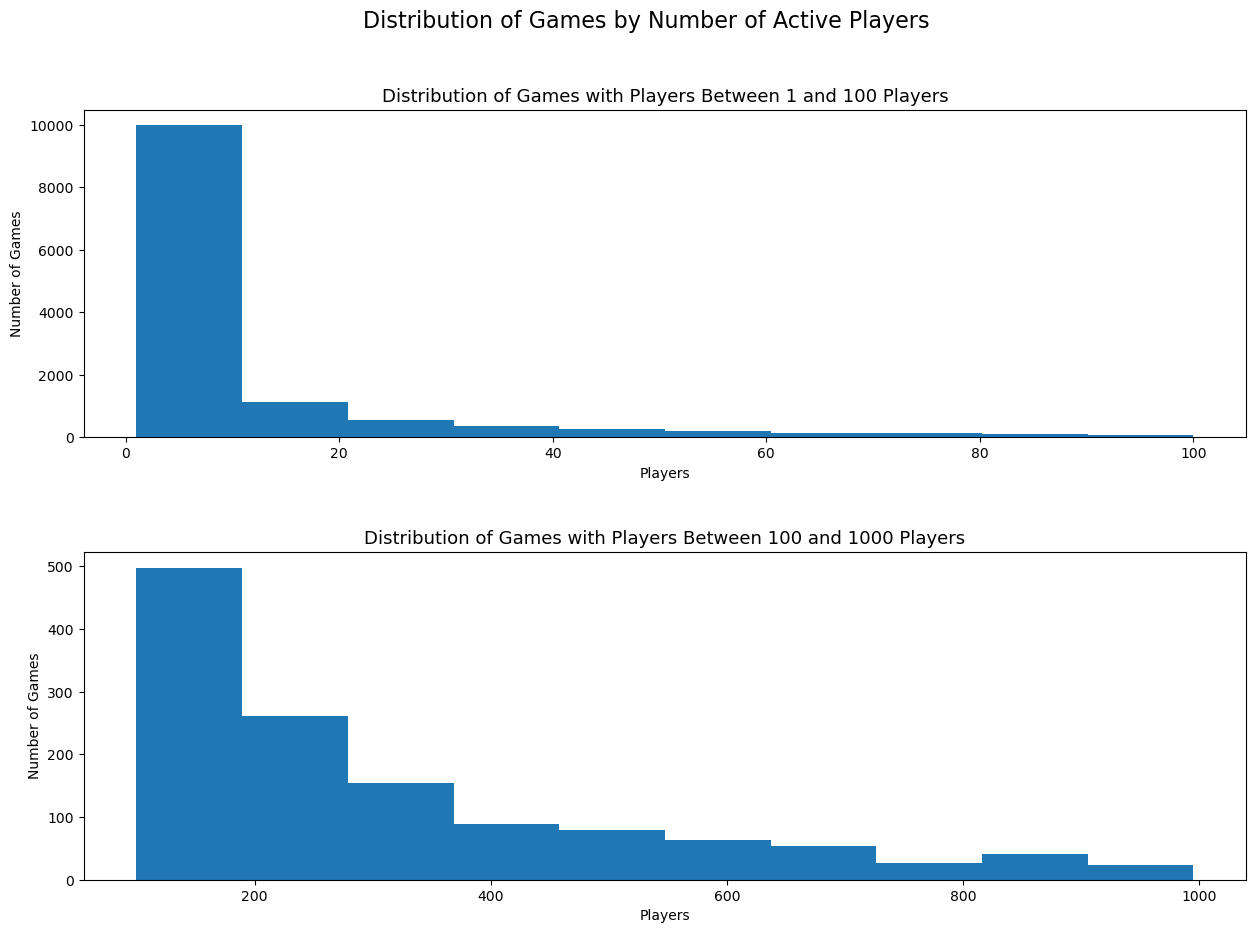

In [5]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    cur = conn.cursor()

    # Games whose release dates and prices are invalid are already filtered out
    # from the scraping process
    cur.execute("""
                SELECT "09_06_1300" 
                FROM player_count 
                WHERE ("09_06_1300" BETWEEN 100 AND 1000)
                """)
    players_lt_200 = [player[0] for player in cur.fetchall()]
    
    cur.execute("""
                SELECT "09_06_1300" 
                FROM player_count 
                WHERE "09_06_1300" BETWEEN 1 AND 100
                """)
    all_players = [player[0] for player in cur.fetchall()]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle("Distribution of Games by Number of Active Players", fontsize=16)

ax1.hist(all_players)
ax1.set_title("Distribution of Games with Players Between 1 and 100 Players", size=13)
ax1.set_xlabel("Players")
ax1.set_ylabel("Number of Games")


ax2.hist(players_lt_200)
ax2.set_title("Distribution of Games with Players Between 100 and 1000 Players", size=13)
ax2.set_xlabel("Players")
ax2.set_ylabel("Number of Games");

plt.subplots_adjust(hspace=0.35)

### Tag-Player Analysis

**Determines the top 5 tags (genres) with the most games from 2006 to 2022**

In [6]:
# Created a table with columns release_year, tag_name, 
# and the number of games associated with that tag
with sqlite3.connect('video_game_data_db.sqlite') as conn:

    query = """
            SELECT substr(game.release_date, 1, 4) AS release_year, tag.name AS tag_name, COUNT(*) AS game_count
            FROM game_tag
            JOIN tag ON game_tag.tag_id = tag.id
            JOIN game ON game_tag.game_id = game.id
            WHERE 
                CAST(substr(game.release_date, 1, 4) AS INT) BETWEEN 2006 AND 2022
                AND game.price != -1
            GROUP BY substr(game.release_date, 1, 4), tag.name
            """
    
    date_tag_gamecount = pd.read_sql(query, conn)

date_tag_gamecount.sample(5, random_state=42)

,release_year,tag_name,game_count
5365,2021,Split Screen,75
4325,2019,Heist,7
199,2007,CRPG,1
3259,2016,Third Person,110
3493,2017,Indie,3793


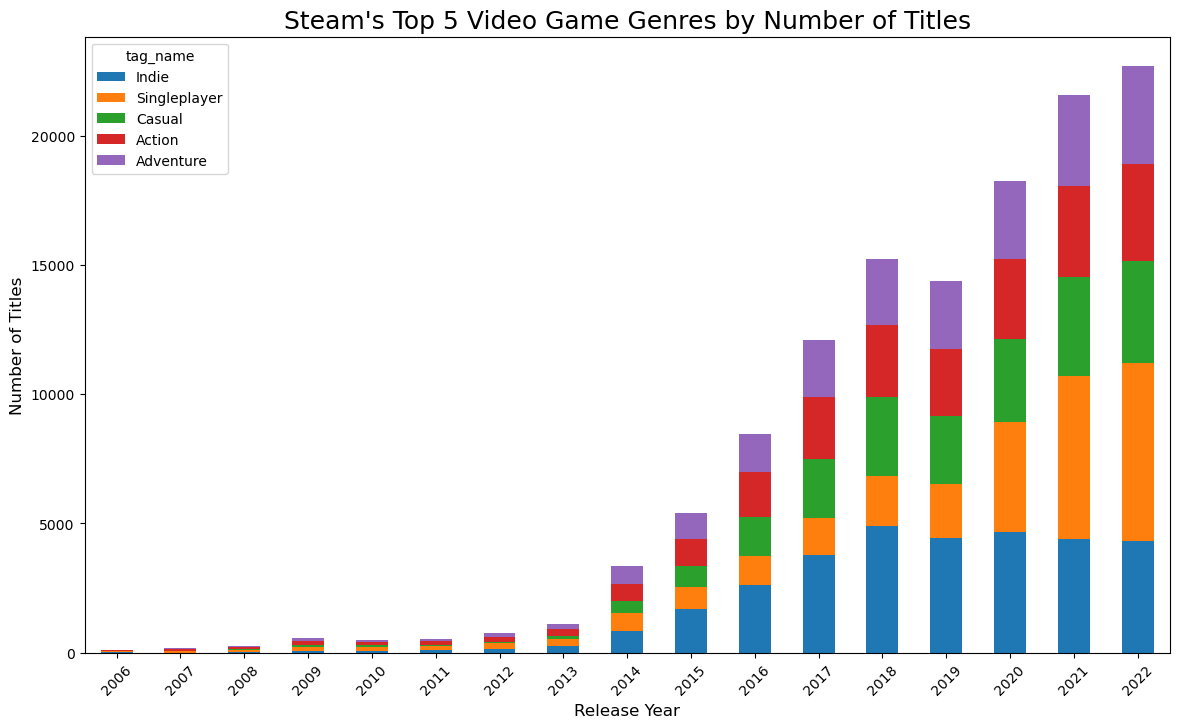

In [7]:
from sklearn.linear_model import LinearRegression

date_tag_gamecount_pivot = date_tag_gamecount.pivot(index='release_year', columns='tag_name', values='game_count')

date_tag_gamecount_pivot.fillna(0, inplace=True)

# Create a dictionary which will be converted to a dataframe
tag_count_slopes = {'tag_name': [], 'game_count': []}
for tag in date_tag_gamecount_pivot.columns:
    X = date_tag_gamecount_pivot.index.values.reshape(-1, 1) # dates
    y = date_tag_gamecount_pivot[tag].values # number of games

    # Linear Regression Model to find slope
    model = LinearRegression()
    model.fit(X, y)

    # Change in the number of games per year
    slope = round(model.coef_[0], 2) 

    tag_count_slopes['tag_name'].append(tag)
    tag_count_slopes['game_count'].append(slope)


# Sorting the dataframe by game count
tag_count_slopes = pd.DataFrame(tag_count_slopes)
tag_count_slopes = tag_count_slopes.sort_values(by='game_count', ascending=False)

# Top 5 tags with the largest game count
top_n_tags = 5
top_tags_by_gamecount = tag_count_slopes['tag_name'][0:top_n_tags]


# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
date_tag_gamecount_pivot[top_tags_by_gamecount].plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Steam's Top 5 Video Game Genres by Number of Titles", size=18)
ax.set_xlabel("Release Year", size=12)
ax.set_xticklabels(labels=date_tag_gamecount_pivot.index, rotation=45)
ax.set_ylabel("Number of Titles", size=12);

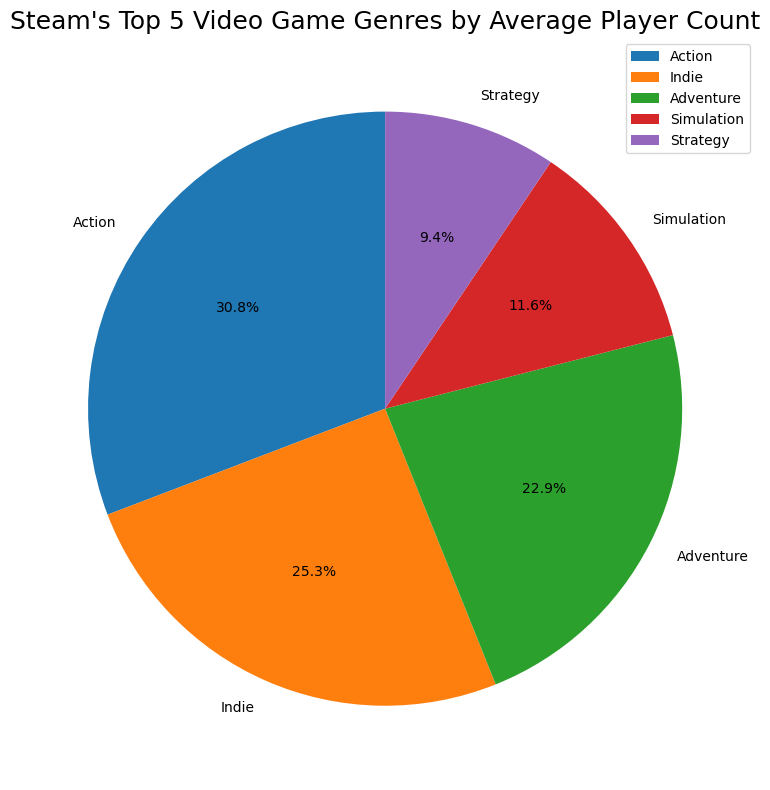

In [8]:
# Created a table with the columns tag_name and its weighted average of players (wavg_players)
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    query = """
            WITH total_games AS (
            SELECT COUNT(*) AS total
            FROM game
            WHERE 
                CAST(substr(release_date, 1, 4) AS INT) >= 2006
                AND price != -1
            )

            SELECT tag.name AS tag_name, SUM("09_06_1300") * COUNT(*) / total_games.total AS wavg_players
            FROM game_tag, total_games
            JOIN tag ON tag.id = game_tag.tag_id
            JOIN game ON game.id = game_tag.game_id
            JOIN player_count ON player_count.id = game_tag.game_id
            WHERE 
                CAST(substr(release_date, 1, 4) AS INT) BETWEEN 2006 AND 2022
                AND price != -1
            GROUP BY tag.name
            """

    tag_playercount = pd.read_sql(query, con=conn)

tag_playercount.set_index('tag_name', inplace=True)
drop_labels = ['Singleplayer', 'Multiplayer'] # irrelevant tags to drop
top_n_tags = 5 # number of tags to consider

# Sort the table by average player count (highest to lowest)
tag_playercount = tag_playercount.sort_values(by='wavg_players', ascending=False)
top_tags_by_playercount = tag_playercount.drop(labels=drop_labels)[0:top_n_tags]

# Plotting
fig, ax = plt.subplots(figsize=(15,8))
top_tags_by_playercount.plot.pie(
    y='wavg_players',
    autopct='%1.1f%%',
    ax=ax,
    startangle=90
);
ax.set_title("Steam's Top 5 Video Game Genres by Average Player Count", size=18)
ax.set_ylabel('')
ax.set_xlabel('')

plt.tight_layout()

In [9]:
with sqlite3.connect('video_game_data_db.sqlite') as conn:
    query = """
            SELECT substr(release_date, 1, 4) AS release_year, tag.name AS tag_name, SUM(price) AS avg_price
            FROM game_tag
            JOIN tag ON tag.id = game_tag.tag_id
            JOIN game ON game.id = game_tag.game_id
            WHERE 
                CAST(substr(release_date, 1, 4) AS INT) >= 2006 
                AND price != -1
            GROUP BY substr(release_date, 1, 4), tag.name
            """
    
    query = """  
            SELECT game.id, game.name, substr(release_date, 1, 4) AS release_year, tag.name AS tag_name, AVG(price) AS avg_price
            FROM game_tag
            JOIN tag ON tag.id = game_tag.tag_id
            JOIN game ON game.id = game_tag.game_id
            JOIN player_count ON player_count.id = game.id
            WHERE 
                "09_06_1300" >= 20 
                AND (CAST(substr(release_date, 1, 4) AS INT) BETWEEN 2006 AND 2022)
                AND price != -1
            GROUP BY substr(release_date, 1, 4), tag.name
            ORDER BY release_year DESC
            """
    
    date_tag_price = pd.read_sql(query, con=conn)

date_tag_price_pivot = date_tag_price.pivot(index='release_year', columns='tag_name', values='avg_price')

date_tag_price_pivot.fillna(0, inplace=True)

date_tag_price_pivot['Action']

release_year
2006    13.573333
2007     9.270000
2008    12.952593
2009    12.361591
2010    19.378889
2011    15.821944
2012    15.261860
2013    18.688980
2014    22.750274
2015    19.554024
2016    20.976517
2017    22.239083
2018    26.918972
2019    25.776609
2020    26.000272
2021    28.519098
2022    28.870065
Name: Action, dtype: float64

Text(0, 0.5, 'Price ($)')

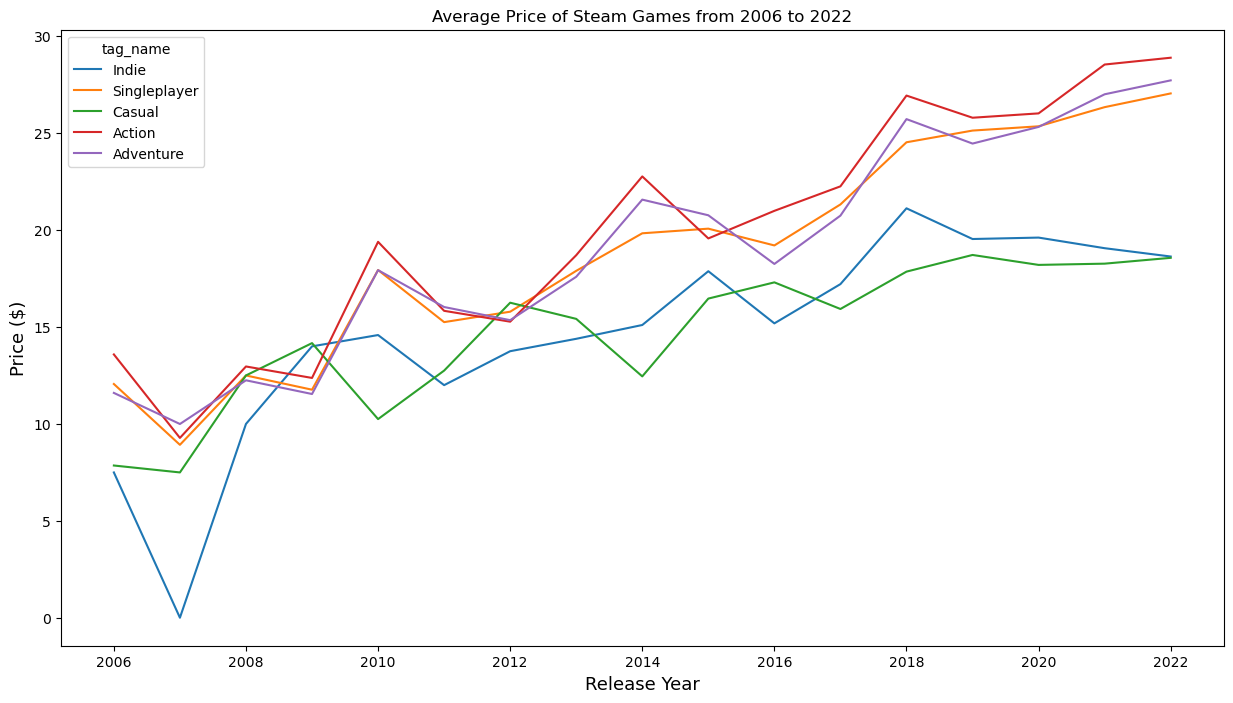

In [10]:
# Plotting
fig, ax = plt.subplots(figsize=(15,8))
date_tag_price_pivot[top_tags_by_gamecount].plot(kind='line', ax=ax)

ax.set_title("Average Price of Steam Games from 2006 to 2022")
ax.set_xlabel("Release Year", size=13)
ax.set_ylabel("Price ($)", size=13)

In [ ]:
raise StopExecution

with (
    sqlite3.connect('../Steam_Games-Predicting_Success/steam_db.sqlite') as source,
    sqlite3.connect('video_game_data_db.sqlite') as destination
):
    source_cursor = source.cursor()
    destination_cursor = destination.cursor()

    source_cursor.execute('SELECT id, release_date FROM game')
    data_to_copy = source_cursor.fetchall()

    for row in data_to_copy:
        id = row[0]
        date = row[1]

        destination_cursor.execute("UPDATE game SET release_date = (?) WHERE id = (?)", (date, id))

    destination.commit()